# Gaussian Mixture Model

- GMM은 선형판별분석의 **일반화 버전**.

$$p(z^{(i)}) \sim \text{multinomial}(\phi) $$

$$p(x^{(i)} | z^{i} = j) \sim N(\mu_j, \sigma_j)$$

- 선형판별분석과 가장 큰 차이점은 레이블 y가 없는 자율학습이라는 것. 대신 y가 아닌 학습데이터로 주어지지 않는 잠재변수(latent variable) z를 사용함. z는 다항분포를 따른다고 가정함. 이렇게 뽑힌 z가 j번째 id일 때, x가 나타날 확률을 j번째에 해당하는 평균과 분산을 모수로 갖는 정규분포를 따를 것이라고 가정함.

- GMM의 로그우도함수는 아래와 같음. $\theta$ (1)z와 관련된 다항분포 파라미터 $\Phi$(2), 각 정뷰분포의 평균 $\mu$(3), 정규분포의 분산 $\sigma$ 세 가지를 가리킴

$$l(\theta) = \sum_{i} \text{log} \   \sum_{z_{i}} p(x^i, z^i, \theta)$$

- z가 학습데이터로 주어진 상황이면, 구하고자 하는 각각의 파리미터들에 대해 앞서 언급한 로그우도 함수를 편미분한 결과가 0인 지점에서, 파라미터를 추정할 수 있음. 그렇지만 z는 잠재변수이기 때문에 위의 로그우도 함수를 최대화하는 파라미터를 direct하게 구할 수 없음. 이 때문에 EM알고리즘을 아래와 같이 적용함

    1. Expectation : 로그우도 함수값의 하한(lower bound)를 구함
    2. Maximization : e-step에서 구한 로그우도 함수값을 최대화하는 파라미터를 찾아냄


- 로그우도 함수의 하한을 구하기 위해서 **jensen's Inequality**를 이용해서 접근해봄. 임의의 함수 f가 볼록함수이고 x가 확률변수이면 다음이 성립됨

$$E[(f(x))] \ge f(E[x])$$

- 그런데 로그 함수는 오목함수이므로 위의 부등식 방향이 반대로 적용될 것임. 또 여기에서 $z^i$에 대한 임의의 확률분포 $Q_i(z^i)$를 상정해 둔다면, Jensen's insquality와 Q를 활용해서 GMM의 로그우도함수를 아래와 같이 다시 적을 수 있음

$$l(\theta) = \sum_{i} \text{log} \   \sum_{z_{i}} p(x^i, z^i, \theta)$$

$$= \sum_{i} \text{log} \   \sum_{z_{i}} Q_i(z^i) \frac{p(x^i, z^i, \theta)}{Q_i(z^i)}$$

$$\ge \sum_{i} \sum_{z_{i}} Q_i(z^i) \text{log} \frac{p(x^i, z^i, \theta)}{Q_i(z^i)}$$

- 그런데 실제 로그우도는$Q_i$와 상관이 없기 때문에 가급적 위 부등식이 '='에 가깝게 정할 수 있으면 좋을 것임. Jensen's Inequality에서 등호는 $f(x)$가 linear인 경우 성립한다고 알려져 있음. 아울러 $Q_i$ 또한 확률분포이므로 그 합이 1이 되어야 함. 두 가지 속성(linear인 경우로 설정, Q_i가 확률분포이므로 합이 1인 것)을 만족하도록 $Q_i$를 정함

$$\frac{p(x^i, z^i, \theta)}{Q_i(z^i)} = c \leftrightarrow Q_i(z^i) \varpropto p(x^i, z^i, \theta)$$

$$\sum_z Q_i(z) = 1$$

- 그런데 Q_i를 z에 대한 사후확률로 정하면 위 두 개의 가정을 만족시킬 수 있음. 즉,

$$Q_i(z^i) = p(x^i, z^i, \theta) / p(x^i, \theta) = p(z^i | x^i, \theta)$$

- 로 두게됨. 요컨데 GMM의 EM알고리즘은 고정된 $\theta$하에서 $Q_i(z^i)$를 구하고, e-step에서 구한 $Q_i(z^i)$하에서 로그우도 함수를 최대화는 $\theta$를 구하는 과정은 iterative하게 구하게 됨.

## 1. Import Libs

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

torch.manual_seed(777)
np.random.seed(777)

## 2. prepare Data

### 2.1 Sampling data from Gaussian Distribution

In [2]:
def sample(mu, var, nb_samples=500):
    out = [torch.normal(mu, var.sqrt()).unsqueeze(0) for i in range(nb_samples)]
    return torch.cat(out)

# generate data
cluster1 = sample(torch.Tensor([7, 9]), torch.Tensor([1, 6]))
cluster2 = sample(torch.Tensor([1.5, 7.5]), torch.Tensor([2,2]))
cluster3 = sample(torch.Tensor([2.5, 1.5]), torch.Tensor([.8, 1]))

In [3]:
print(cluster1.size())

torch.Size([500, 2])


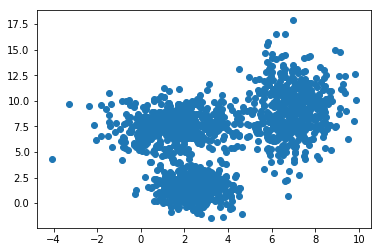

In [4]:
data = torch.cat([cluster1, cluster2, cluster3])
plt.scatter(data[:, 0].numpy(), data[:, 1].numpy())

## 3. GMM with EM
### 3.1 init Paramerters

In [5]:
N = data.size(0) # num data
M = data.size(1) # dimension
K = 3 # sampling from 3 distributions

# init
idxs = torch.from_numpy(np.random.choice(N, K, replace=False))
mu = data[idxs]
var = torch.ones(K, M) # 3, 2 shape=(3, 2)
phi = torch.ones(K)/K # prior

### 3.2 Multivariate Gaussian likelihoods func
PDF of multivariate gaussian is<br>

$$P(x; \mu, \sigma) = \frac{1}{\sqrt{2 \pi | \sigma |}} exp\Big(- \frac{1}{2}(x - \mu)^{T} \Sigma^{-1}(x - \mu) \Big)$$
    - consider diag convariance matrix $I \sigma^2 = \sum$

1. the determinent is
$$| \Sigma| = \prod_{j=1}^N \sigma_{j}^2$$<br>

2. the inverse of covariance matrix is
$$Tr(\Sigma^{-1}) = [ \sigma_1^{-2}, ..., \sigma_{N}^{-2} ]$$<br>

3. the exponent is simplified to
$$\frac{1}{2}((x - \mu) \odot (x - \mu))^{T} \sigma^{-2}$$

In [6]:
def get_k_likelihoods(X, mu, var):
    if var.eq(0).any():
        raise Exception('variances must be nonzero')
    
    coeff = 1. / ((2*np.pi * var).prod(dim=1)).sqrt() # (K )
    sigma_inv = 1./var # (K, features)
    diff = X - mu.unsqueeze(1) # (K, examples, feature)    
    exponent = -0.5 * ( diff **2 @ sigma_inv.unsqueeze(2) )
    likelihoods = coeff.view(K,1,1) * torch.exp( exponent )

    return likelihoods.squeeze(2)

### 3.2 posterior function(사후확률)
$$P(z|x) = \frac{p(x|z)p(z)}{\sum_{k=1}^K p(x|z=k)p(z=k)}$$

In [7]:
def get_posteriors(likelihoods, phi, eps=1e-6):
    Joint_sum = torch.sum( likelihoods * phi.unsqueeze(1) , dim=0, keepdim=True)
    return (likelihoods * phi.unsqueeze(1) / (Joint_sum + eps))

### 3.4 parameter update func

In [8]:
def get_parameters(X, w, eps=1e-6):
    
    # compute `N_k` the proxy "number of points" assigned to each distribution.
    K = w.size(0)
    N_k = torch.sum(w, dim=1) + eps # (K)
    
    N_k = N_k.view(K, 1, 1)
    
    phi = N_k / N_k.sum()

    # tile X on the `K` dimension
    X = X.clone().unsqueeze(0).repeat(K, 1, 1)

    # get the means by taking the weighted combination of points
    mu = w.unsqueeze(1) @ X # (K, 1, features)
    mu = mu / N_k

    # compute the diagonal covar. matrix, weighting contributions from each point
    A = X - mu
    var = w.unsqueeze(1) @ (A ** 2) # (K, 1, features)
    var = var / N_k

    # recompute the mixing probabilities
    m = X.size(1) # nb. of training examples

    return mu.squeeze(1), var.squeeze(1), phi.view(-1)

### 3.5 density plot function

In [9]:
def plot_density(mu, var, pi, N=50, X_range=(-5, 15), Y_range=(-5, 15), i=0):
    """ Get the mesh to compute the density on. """
    X = np.linspace(*X_range, N)
    Y = np.linspace(*Y_range, N)
    X, Y = np.meshgrid(X, Y)
    
    # get the design matrix
    points = np.concatenate([X.reshape(-1, 1), Y.reshape(-1, 1)], axis=1)
    points = torch.from_numpy(points).float()
    P = get_k_likelihoods(points, mu, var) # compute the densities under each mixture

    # sum the densities to get mixture density
    Z = torch.sum(P, dim=0).numpy().reshape([N, N])
    
    fig = plt.figure(figsize=(15, 15))
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True, cmap=cm.inferno)
    cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.15, cmap=cm.inferno)

    # adjust the limits, ticks and view angle
    ax.set_zlim(-0.15,0.2)
    ax.set_zticks(np.linspace(0,0.2,5))
    ax.view_init(27, -21)
#     plt.savefig('fig_{}.png'.format(i), dpi=400, bbox_inches='tight')
    plt.show()
    plt.pause(0.01)

## 4. Training with EM Algorithm

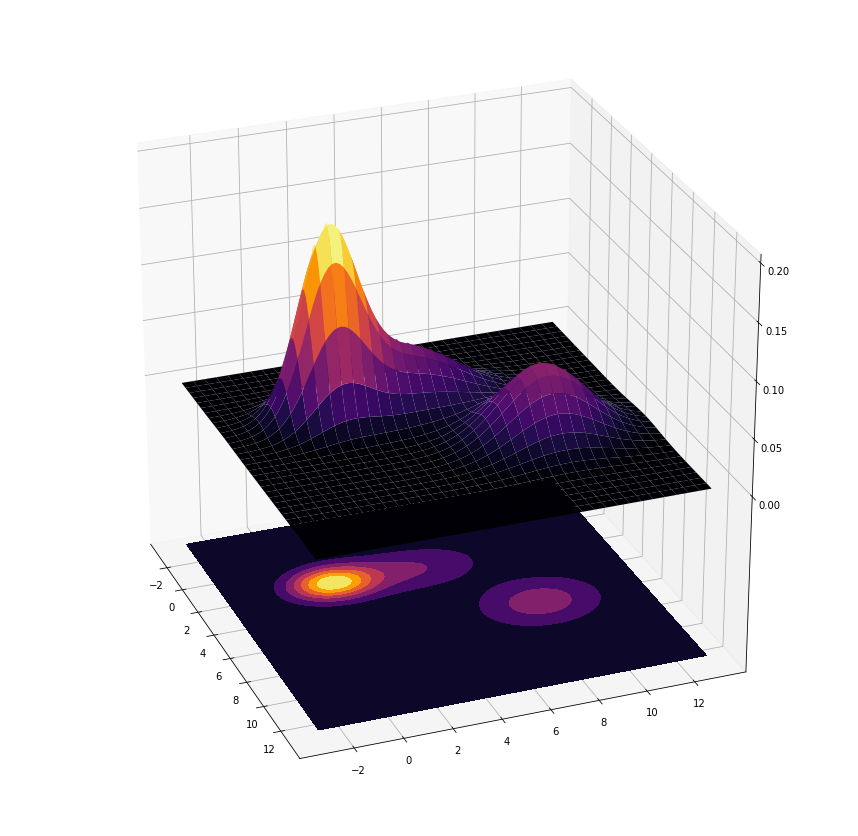

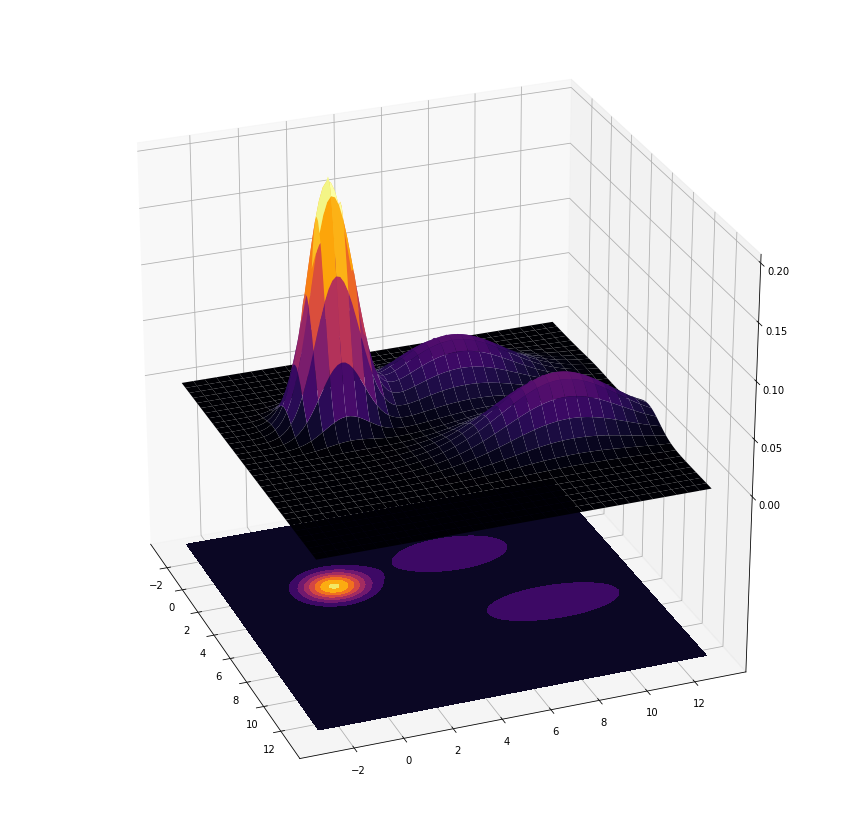

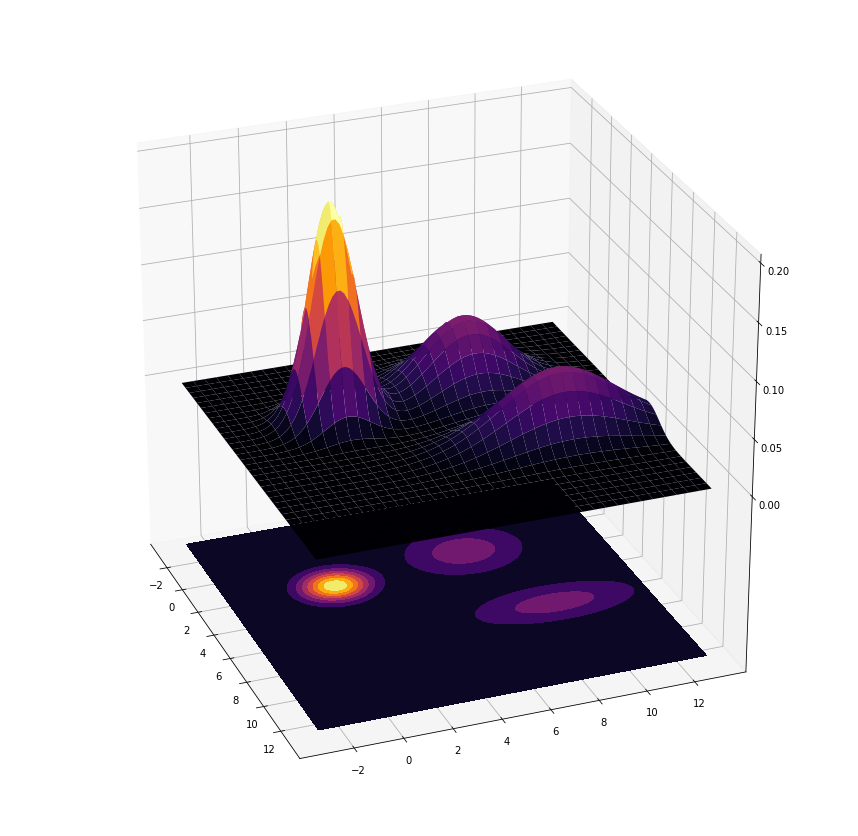

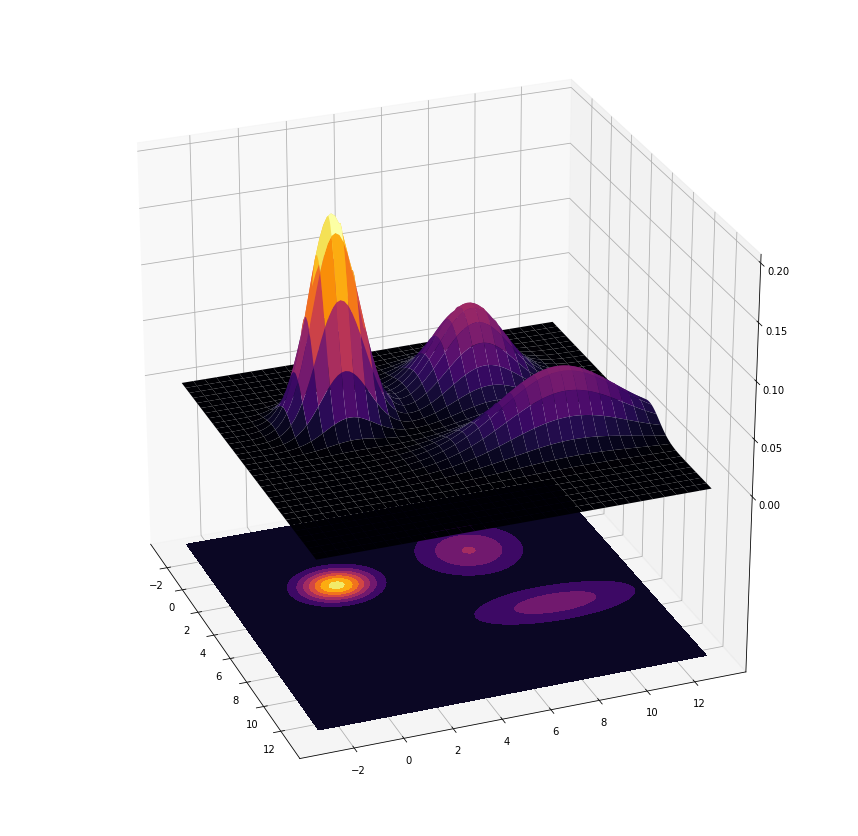

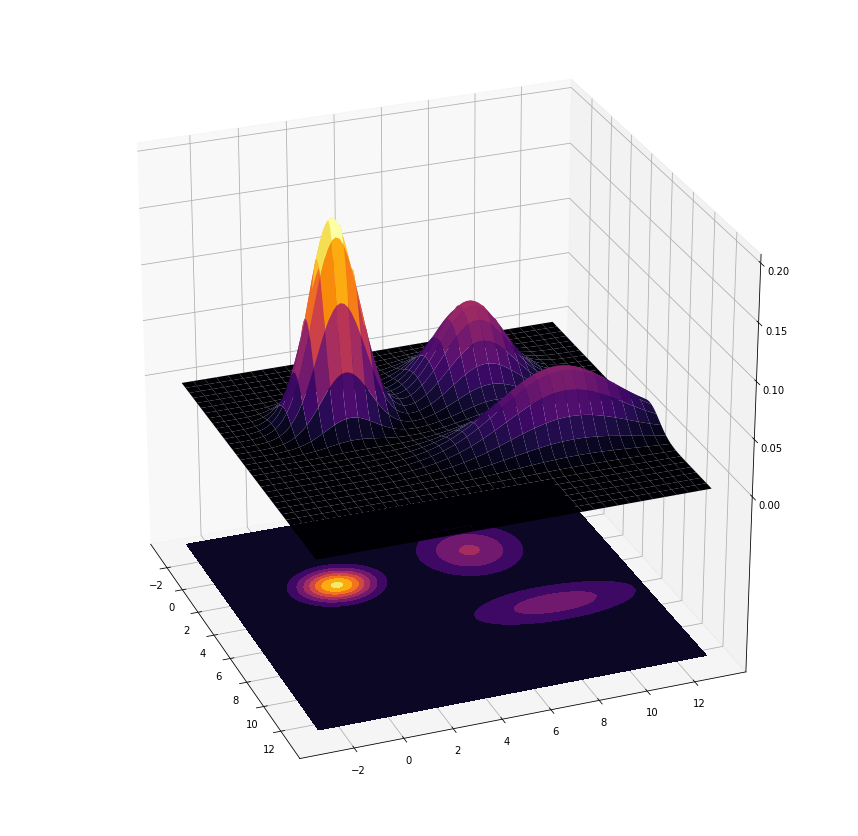

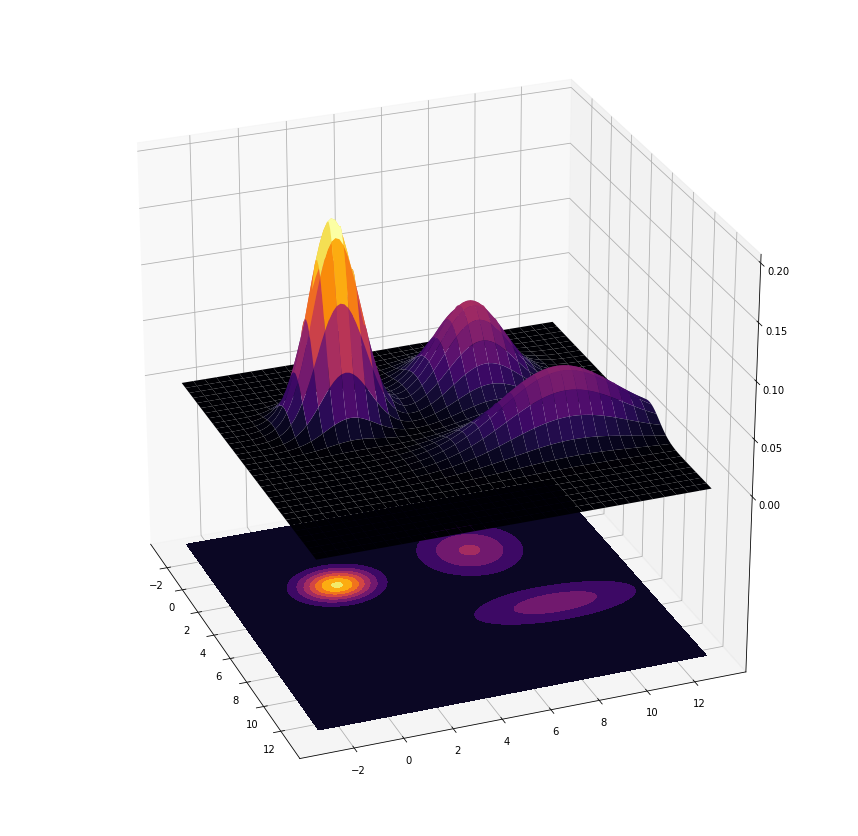

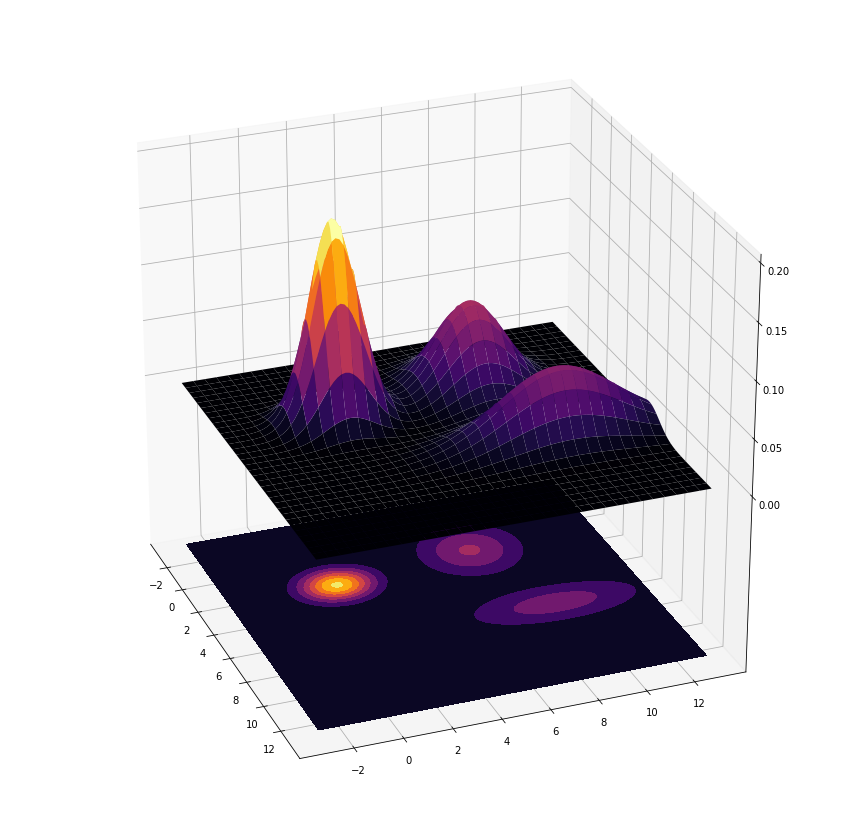

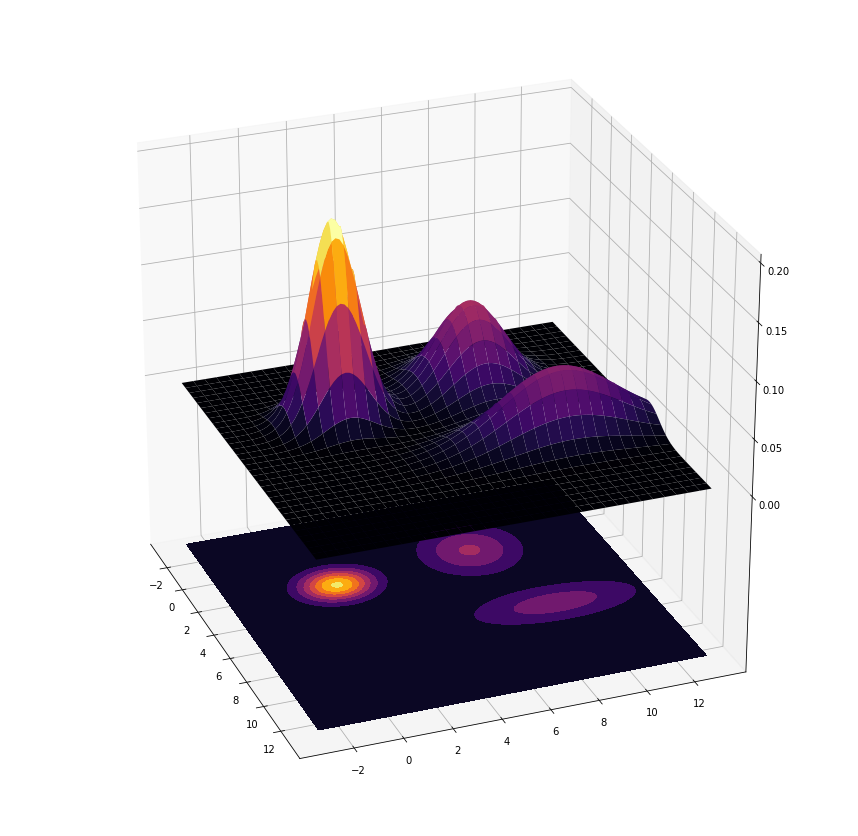

In [10]:
plt.ion() # Ploting

# Stoping Criterions
max_iter = 1000
prev_cost = float('inf')
thresh = 1e-4

# training loop
for i in tqdm(range(max_iter)):

    # (E-step) Calculate Posterior = mixture membership w
    likelihoods = get_k_likelihoods(data, mu, var)  # likelihoods p(x|z) under the parameters mu, var, phi 
    w = get_posteriors(likelihoods,phi)             # posterior P(Z|X)
    
    # (M-Step) Update parameters using w
    mu, var, phi = get_parameters(data, w)
    
    
    # Ploting 
    if i % 2 == 0:
        plot_density(mu, var, phi, N=100, X_range=(-3, 13), Y_range=(-3, 13), i=i)
    
    
    # Calculate Current log-likelihood
    sum_over_k = likelihoods*phi.unsqueeze(1).sum(dim=0)      # get weight probability of each point under each k
    sum_over_m = torch.sum(torch.log(sum_over_k + 1e-6))      # take log probability over each example `m`
    cost = - sum_over_m / likelihoods.size(1)

    # Exit Condition
    diff = prev_cost - cost
    if np.abs(diff) < thresh:
         break
    prev_cost = cost
    
plt.ioff() # Ploting